In [4]:
# optimal PID controller tuning
# Victor M. Zavala
# UW-Madison, 2017

using Ipopt
using Plasmo
using JuMP
using PyPlot

# sets
NS=3;       # Number of scenarios 
 N=100;     # Number of timesteps
Tf=10;      # Final time
 h=Tf/N;    # Time step
 T=1:N;     # Set of times
Tm=1:N-1;   # Set of times minus one

# set time vector
time=zeros(N);
for t=1:N
 time[t] = h*(t-1);
end

# scenario data
K=zeros(NS);   # system gain
x0=zeros(NS);  # initial state
Kd=zeros(NS);  # disturbance gain
tau=zeros(NS); # time constaint
xsp=zeros(NS); # set-point
d=zeros(NS);   # disturbance 

  K[1] =  1.0;
 x0[1] =  0.0;
 Kd[1] =  0.5;
tau[1] =  1.0;
xsp[1] = -1.0;
  d[1] = -1.0;

  K[2] =  1.0;
 x0[2] =  0.0;
 Kd[2] =  0.5;
tau[2] =  1.0;
xsp[2] = -2.0;
  d[2] = -1.0;

  K[3] =  1.0;
 x0[3] =  0.0;
 Kd[3] =  0.5;
tau[3] =  1.0;
xsp[3] =  1.0;
  d[3] = -1.0;

include("createPIDmodel.jl")  #scenario model building function

# create two-stage graph moddel
PID=GraphModel()
master = Model()
master_node = add_node(PID,master)

# add variables to parent node 
@variable(master, -10<= Kc <=10)
@variable(master,-100<=tauI<=100)
@variable(master,-100<=tauD<=1000)

# create array of children models
PIDch=Array{NodeOrEdge}(NS)
for s in 1:NS           
           # get scenario model
           bl = get_scenario_model(s)
           child = add_node(PID,bl)
           # add children to parent node
           PIDch[s] = child
           # link children to parent variables
           @linkconstraint(PID, bl[:Kc]==Kc)
           @linkconstraint(PID, bl[:tauI]==tauI)
           @linkconstraint(PID, bl[:tauD]==tauD)    
end

# solve with Ipopt
PID.solver = IpoptSolver()
solve(PID)

# get controller parameters
println(getvalue(Kc))
println(getvalue(tauI))
println(getvalue(tauD))

# plot responses
x=zeros(NS,N)
for s in 1:NS
    for j=1:N
    x[s,j]=getvalue(getindex(PIDch[s],:x)[j]) 
    end
end

println(getgraphobjectivevalue(PID))


Creating flattened graph model...
Finished model instantiation


This is Ipopt version 3.12.1, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     4785
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     3570

Total number of variables............................:     1212
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      612
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1206
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

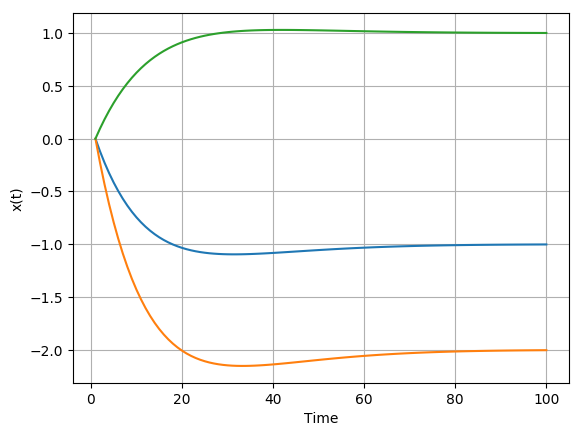

In [2]:
plot(T, x[1,:]);
plot(T, x[2,:]);
plot(T, x[3,:]);
xlabel("Time")
ylabel("x(t)")
grid("on")